In [17]:
import numpy as np
import pandas as pd
import os
from osgeo import gdal
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

# A list of "random" colors (for a nicer output)
COLORS = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941"]

In [2]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

In [10]:
raster_data_path = "_ags_3a9d7f40_c458_4cfe_8d69_69f87c8a1e90.png"
#raster_label_path = "/Users/enrique/Documents/ML_Project/data/image/15-9626-12350.png"
output_fname = "\\Users\\enrique\\Documents\\ML_Project\\ML-Satellite-image-Classification-Project\dataclassification.tiff"
train_data_path = "\\Users\\enrique\\Documents\\ML_Project\\ML-Satellite-image-Classification-Project\shapefiles"
validation_data_path = "\\Users\\enrique\\Documents\\ML_Project\\ML-Satellite-image-Classification-Project\shapefiles"

In [11]:
raster_dataset = gdal.Open(raster_data_path, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
bands_data = []
for b in range(1, raster_dataset.RasterCount+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape

In [13]:
files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(train_data_path, f)
              for f in files if f.endswith('.shp')]

labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform,
                                   proj)
is_train = np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
training_samples = bands_data[is_train]

In [18]:
x = pd.DataFrame(labeled_pixels)

In [20]:
labeled_pixels.shape

(2884L, 6053L)

In [21]:
bands_data.shape

(2884L, 6053L, 3L)

In [23]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(training_samples, training_labels)

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

In [39]:
n_samples = rows*cols
flat_pixels = bands_data.reshape((n_samples, n_bands))
result = classifier.predict(flat_pixels)
classification = result.reshape((rows, cols))

In [40]:
classification = classification.astype(int)

In [41]:
classification

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ..., 
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

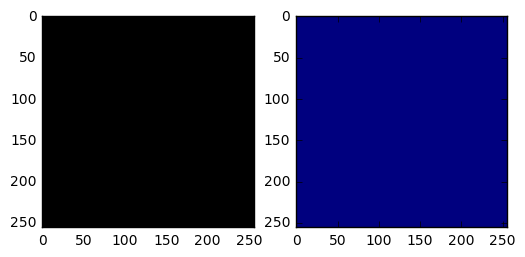

In [42]:
from matplotlib import pyplot as plt
f = plt.figure()
f.add_subplot(1, 2, 2)
r = bands_data[:,:,0]
g = bands_data[:,:,1]
b = bands_data[:,:,2]
rgb = np.dstack([r,g,b])
f.add_subplot(1, 2, 1)
plt.imshow(rgb/255)
f.add_subplot(1, 2, 2)
plt.imshow(classification)
plt.show()

In [19]:
write_geotiff(output_fname, classification, geo_transform, proj)

In [ ]:
#files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
#classes = [f.split('.')[0] for f in files]
#shapefiles = [os.path.join(train_data_path, f)
              #for f in files if f.endswith('.shp')]

#labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform,
                                   #proj)
labeled_pixels = bands_label
is_train = np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
training_samples = bands_data[is_train]

In [26]:
#shapefiles = [os.path.join(validation_data_path, "%s.shp" % c)
              #for c in classes]

#verification_pixels = vectors_to_raster(shapefiles, rows, cols,
                                        #geo_transform, proj)
verification_pixels = bands_label
for_verification = np.nonzero(verification_pixels)
verification_labels = verification_pixels[for_verification]
predicted_labels = classification[for_verification]

In [27]:
print("Confussion matrix:\n%s" %
      metrics.confusion_matrix(verification_labels, predicted_labels))

Confussion matrix:
[[1813]]


In [28]:
target_names = ['Class %s' % s for s in classes]
print("Classification report:\n%s" %
      metrics.classification_report(verification_labels, predicted_labels,
                                    target_names=target_names))
print("Classification accuracy: %f" %
      metrics.accuracy_score(verification_labels, predicted_labels))

NameError: name 'classes' is not defined